> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: We investigate a dataset of movies to explore some movies popularity as well as the factors impacting their quality such as genre and budget. This operation will improve the analysis skills and leads to determining the criteria for movies success.. 


### Question(s) for Analysis
>**Tip**:1.	what genre is more popular from year to year?
2.	What are the properties of the movies that have high revenues?
3.	Did movies with higher vote count received a better rating?
4.	What were the most popular produced genres in 2000 compared to 2015?
5.	How did the number of produced movies changed over time?
. 

In [17]:
# Using this cell to set up import statements for all of the packages that are considered to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

"""Changing scientific numbers to numeric numbers"""
#https://stackoverflow.com/questions/38689125/how-to-get-rid-of-pandas-converting-large-numbers-in-excel-sheet-to-exponential
pd.options.display.float_format = '{:.2f}'.format

In [18]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [19]:
# Loading the data and having a look at the first few lines
df = pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.99,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.50,2015,137999939.28,1392445892.52
1,76341,tt1392190,28.42,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.10,2015,137999939.28,348161292.49
2,262500,tt2908446,13.11,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.30,2015,101199955.47,271619025.41
3,140607,tt2488496,11.17,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.50,2015,183999919.04,1902723129.80
4,168259,tt2820852,9.34,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.30,2015,174799923.09,1385748801.47


In [20]:
# identifying datatypes for each column
df.info(),
print('-------------')
print('Dataframe contains {} rows and {} columns'.format(df.shape[0],df.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

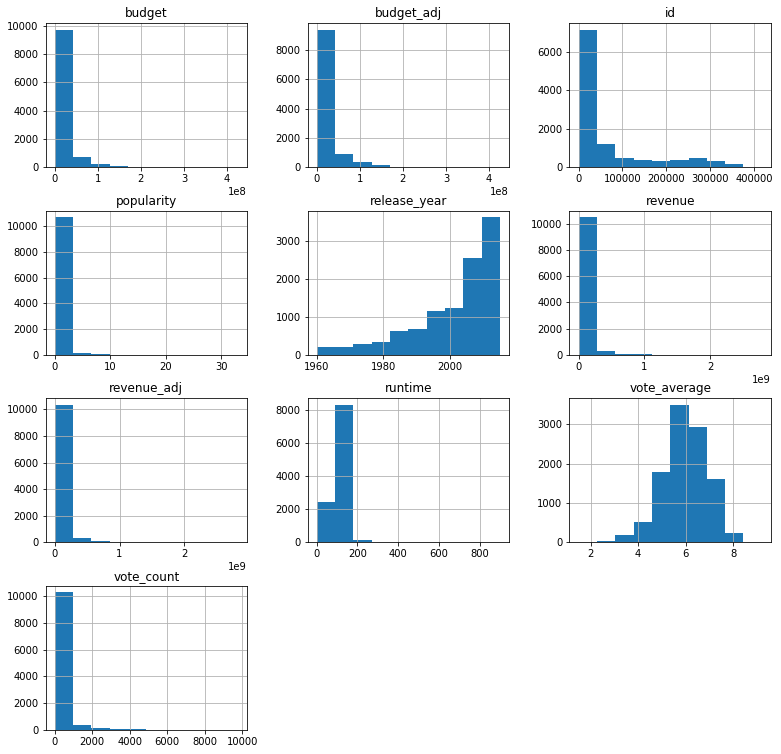

In [21]:
# displaying figures to summaries data
df.hist(figsize=(13,13));

In [22]:
# presenting descriptive statisctices for each column
df.describe()


,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.00,10866.00,10866.00,10866.00,10866.00,10866.00,10866.00,10866.00,10866.00,10866.00
mean,66064.18,0.65,14625701.09,39823319.79,102.07,217.39,5.97,2001.32,17551039.82,51364363.25
std,92130.14,1.00,30913213.83,117003486.58,31.38,575.62,0.94,12.81,34306155.72,144632485.04
min,5.00,0.00,0.00,0.00,0.00,10.00,1.50,1960.00,0.00,0.00
25%,10596.25,0.21,0.00,0.00,90.00,17.00,5.40,1995.00,0.00,0.00
50%,20669.00,0.38,0.00,0.00,99.00,38.00,6.00,2006.00,0.00,0.00
75%,75610.00,0.71,15000000.00,24000000.00,111.00,145.75,6.60,2011.00,20853251.08,33697095.72
max,417859.00,32.99,425000000.00,2781505847.00,900.00,9767.00,9.20,2015.00,425000000.00,2827123750.41



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [23]:
df['revenue_adj'].replace(0, np.NAN, inplace=True)
df['revenue'].replace(0, np.NAN, inplace=True)
df['budget_adj'].replace(0, np.NAN, inplace=True)
df['budget'].replace(0, np.NAN, inplace=True)
df['runtime'].replace(0, np.NAN, inplace=True)

df.dropna(axis=0, inplace=True)

In [24]:
# Seperating columns
df_c = (df['cast'].str.split('|', expand=True).rename(columns=lambda x: f"cast_{x+1}"))
df_d = (df['director'].str.split('|', expand=True).rename(columns=lambda x: f"director_{x+1}"))
df_k = (df['keywords'].str.split('|', expand=True).rename(columns=lambda x: f"keywords_{x+1}"))
df_g = (df['genres'].str.split('|', expand=True).rename(columns=lambda x: f"genres_{x+1}"))
df_p = (df['production_companies'].str.split('|', expand=True).rename(columns=lambda x: f"production_companies_{x+1}"))

#Checking df_c if split was conducted as intended
df_c.head()

,cast_1,cast_2,cast_3,cast_4,cast_5
0,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,Vincent D'Onofrio,Nick Robinson
1,Tom Hardy,Charlize Theron,Hugh Keays-Byrne,Nicholas Hoult,Josh Helman
2,Shailene Woodley,Theo James,Kate Winslet,Ansel Elgort,Miles Teller
3,Harrison Ford,Mark Hamill,Carrie Fisher,Adam Driver,Daisy Ridley
4,Vin Diesel,Paul Walker,Jason Statham,Michelle Rodriguez,Dwayne Johnson


In [25]:
"""Joining the seperated columns to the original dataframe and
dropping unneeded columns for the analysis"""

df = df.join([df_c, df_d, df_k, df_g, df_p])
df = df.drop(['cast', 'keywords', 'director', 'genres', 'production_companies', 'imdb_id', 'homepage', 'overview', 'release_date', 'tagline'], axis=1)

In [26]:
"""Checking duplicates"""
df.duplicated().sum()

0

In [27]:
"""Checking datatype"""
df.dtypes

id                          int64
popularity                float64
budget                    float64
revenue                   float64
original_title             object
runtime                   float64
vote_count                  int64
vote_average              float64
release_year                int64
budget_adj                float64
revenue_adj               float64
cast_1                     object
cast_2                     object
cast_3                     object
cast_4                     object
cast_5                     object
director_1                 object
director_2                 object
director_3                 object
director_4                 object
director_5                 object
director_6                 object
keywords_1                 object
keywords_2                 object
keywords_3                 object
keywords_4                 object
keywords_5                 object
genres_1                   object
genres_2                   object
genres_3      

In [28]:
df['original_title'].value_counts().head()

Halloween II            2
The Thing               2
Clash of the Titans     2
The Three Musketeers    2
Halloween               2
Name: original_title, dtype: int64

In [29]:
"""Checking  dubplicated original_titles"""
limit_4_title = df['original_title'].value_counts().index.tolist()
limit_4_title = limit_4_title[:4]
limit_4_title

limit_4_id = df['original_title'].value_counts().index.tolist()

def check_double_title(names):
    for limit in limit_4_title:
        df_title = df[df['original_title'] == limit]
        print(df_title.iloc[:,:5])
        print("***********************************")
        
check_double_title(limit_4_title)

         id  popularity      budget     revenue original_title
1546  24150        0.57 15000000.00 39421467.00   Halloween II
8391  11281        0.56  2500000.00 25533818.00   Halloween II
***********************************
         id  popularity      budget     revenue original_title
3472  60935        1.01 35000000.00 28128670.00      The Thing
8890   1091        2.36 10000000.00 13782838.00      The Thing
***********************************
         id  popularity       budget      revenue       original_title
1940  18823        2.09 125000000.00 232713139.00  Clash of the Titans
8425  10323        0.20  15000000.00  41092328.00  Clash of the Titans
***********************************
          id  popularity      budget      revenue        original_title
3425   52451        1.41 75000000.00 132274484.00  The Three Musketeers
10251  10057        0.79 30000000.00  53898845.00  The Three Musketeers
***********************************


In [30]:
print('Dataframe contains {} rows and {} columns'.format(df.shape[0],df.shape[1]))

Dataframe contains 1287 rows and 37 columns


In [31]:
""" I had to make some changes such as: Correcting spelling, capitalization of the some column headers. Removing useful columns. Filter the data to include valid and correct data.
Finally, the results indicated that there are some films with similar titles but different content. Consequently, no more rows will to be dropped. The drop of all rows containing related nan-values has resulted in a decrease in the dataframe. This will influence the size of the dataframe.
"""

' I had to make some changes such as: Correcting spelling, capitalization of the some column headers. Removing useful columns. Filter the data to include valid and correct data.\nFinally, the results indicated that there are some films with similar titles but different content. Consequently, no more rows will to be dropped. The drop of all rows containing related nan-values has resulted in a decrease in the dataframe. This will influence the size of the dataframe.\n'

In [33]:
#Despite having the same title, the movies differ in other columns, according to the results. As a result, the author implies that films with the same title but distinct substance exist. As a result, there is no need to drop any more rows. The dataframe has shrunk dramatically due to the removal of all rows containing relevant nan-values. Only 1287 movies will be considered in the study at this time. This will have an impact on the answers to the research questions.

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (Which genres are most popular from year to year!)

In [34]:
# Selecting genres columns for the analysis of the original data frame
df_genres = df.loc[:, 'genres_1': 'genres_5' ]
# Adding release year to df_genres
df_genres_dates = df_genres.join(df['release_year'])


In [35]:
years = df_genres_dates['release_year'].unique() #creates an array of years mentioned in release year 
most_common = [] #creates a list of tuples for most common genres in specific years

#for loop to create most_common list
for year in years:
    #creates df filtered by every year mentioned in years
    a = df_genres_dates[df_genres_dates['release_year'] == year] 
    #drops columns "release_year to perferm stack value count in next line
    b = a.drop(['release_year'], axis = 1)
    #performs value count trough genres_1 - genres_5 and stores the index of maximum count
    c = b.stack().value_counts().idxmax() 

    #creates a masked DataFrame for respective years
    x = df[df['release_year'] == year]
    #creates the mean of vote_average and stores the index of maximum value
    y = x.groupby(['genres_1'])['vote_average'].mean().idxmax()
    if c == y:
        z = 'Equal'
    else:
        z = 'Not equal'
        #appends year with value count trough genres_1 - genres_5, the highest average vote_average and indicates if the resulting columns match
    most_common.append((year, c, y, z))

#creates df for list of tuples named most_common
df_most_popular = pd.DataFrame(most_common, columns=['release_year', 'popular_produced_genre', 'popular_voted_gerne', 'is_equal']).sort_values('release_year').reset_index().drop(['index'], axis=1)
df_most_popular

,release_year,popular_produced_genre,popular_voted_gerne,is_equal
0,1961,Family,Comedy,Not equal
1,1962,Action,Adventure,Not equal
2,1963,Action,Action,Equal
3,1964,Music,Adventure,Not equal
4,1965,Action,Adventure,Not equal
5,1967,Action,Action,Equal
6,1969,Action,Adventure,Not equal
7,1971,Thriller,Action,Not equal
8,1972,Crime,Drama,Not equal
9,1973,Thriller,Drama,Not equal


In [36]:
df_most_popular['is_equal'].value_counts()

Not equal    41
Equal        10
Name: is_equal, dtype: int64

### Research Question 2  (2.	What are the properties of the movies that have high revenues?!)

In [37]:
# copying the original DataFrame
df_revenue = df

In [38]:
#classifications of the revenue
df_revenue['revenue_adj'].describe()

count         1287.00
mean     199177499.23
std      296851462.45
min             43.00
25%       27648902.20
50%       86747695.58
75%      235117806.64
max     2827123750.41
Name: revenue_adj, dtype: float64

In [39]:
#Creating colomn 'revenue_level' is created to classify columns based on revenues

bin_edges = [2.37,10465848.09,43956661.16,131648235.91,2827123750.41]
bin_names = ['very low' ,'low' ,'medium' ,'high' ] 
df_revenue['revenue_level'] = pd.cut(df_revenue['revenue_adj'], bin_edges, labels=bin_names)

In [40]:
#Creating  revenue_levels classification 
df_revenue['revenue_level'].unique()
revenue_levels = df_revenue['revenue_level'].unique().tolist()
del revenue_levels[-1]

In [41]:
#nesting a  dictionary is based on revenue_levels

movie_data = {}

for level in revenue_levels:
    
    #stack.value_counts seciton
    grouped_data = df_revenue[df_revenue['revenue_level'] == level]
        #director
    director = grouped_data.loc[:, 'director_1': 'director_6']
    frequent_director = director.stack().value_counts().idxmax()
        #cast
    cast = grouped_data.loc[:, 'cast_1': 'cast_5']
    frequent_cast = cast.stack().value_counts().idxmax()
        #genres
    genres = grouped_data.loc[:, 'genres_1': 'genres_5']
    frequent_genres = genres.stack().value_counts().idxmax()
        #production companies
    production = grouped_data.loc[:, 'production_companies_1': 'production_companies_5']
    frequent_production = production.stack().value_counts().idxmax()
        #release_year
    release_year = grouped_data['release_year'].value_counts().idxmax()
    
    #average section
    avg_duration = grouped_data['runtime'].mean()
    avg_budget = grouped_data['budget_adj'].mean()
    avg_vote = grouped_data['vote_average'].mean()
    
    #creating nested dictionary
    movie_data[level] = {'avg_duration' : avg_duration, 
                         'frequent_director' : frequent_director, 
                         'avg_budget' : avg_budget, 
                         'avg_vote' : avg_vote,
                        'frequent_cast' : frequent_cast,
                        'frequent_genres' : frequent_genres,
                        'release_year' : release_year,
                        'frequent_production_companies' : frequent_production}

In [42]:
#converting the dictionary to the dataframe

movie_classes = []
frames = []

for movie_class, d in movie_data.items():
    movie_classes.append(movie_class)
    frames.append(pd.DataFrame.from_dict(d, orient='index'))
    
properties = pd.concat(frames, keys=movie_classes)  

properties.columns = ['values']
properties

values
high     avg_duration                               117.54
         frequent_director                Steven Spielberg
         avg_budget                            95442930.57
         avg_vote                                     6.52
         frequent_cast                          Matt Damon
         frequent_genres                            Action
         release_year                                 2011
         frequent_production_companies  Universal Pictures
low      avg_duration                               105.01
         frequent_director                  John Carpenter
         avg_budget                            25129745.42
         avg_vote                                     6.17
         frequent_cast                       Colin Farrell
         frequent_genres                             Drama
         release_year                                 2011
         frequent_production_companies  Universal Pictures
medium   avg_duration                               107.83
         frequent_director                  Clint Eastwood
         avg_budget                            39912951.34
         avg_vote                                     6.17
         frequent_cast                       Jason Bateman
         frequent_genres                             Drama
         release_year                                 2011
         frequent_production_companies        Warner Bros.
very low avg_duration                               102.02
         frequent_director                  Barry Levinson
         avg_budget                            10380165.24
         avg_vote                                     5.99
         frequent_cast                          Ellen Page
         frequent_genres                             Drama
         release_year                                 2010
         frequent_production_companies           Lionsgate

In [43]:
df_revenue.corr()


,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
id,1.00,0.19,-0.05,-0.03,-0.01,0.06,0.00,0.49,-0.12,-0.10
popularity,0.19,1.00,0.43,0.59,0.32,0.74,0.36,0.06,0.42,0.55
budget,-0.05,0.43,1.00,0.71,0.34,0.58,0.08,0.18,0.99,0.57
revenue,-0.03,0.59,0.71,1.00,0.37,0.78,0.30,0.03,0.71,0.91
runtime,-0.01,0.32,0.34,0.37,1.00,0.43,0.39,-0.07,0.36,0.37
vote_count,0.06,0.74,0.58,0.78,0.43,1.00,0.46,0.07,0.57,0.70
vote_average,0.00,0.36,0.08,0.30,0.39,0.46,1.00,-0.16,0.09,0.32
release_year,0.49,0.06,0.18,0.03,-0.07,0.07,-0.16,1.00,0.06,-0.23
budget_adj,-0.12,0.42,0.99,0.71,0.36,0.57,0.09,0.06,1.00,0.61
revenue_adj,-0.10,0.55,0.57,0.91,0.37,0.70,0.32,-0.23,0.61,1.00


In [44]:
# Did movies with higher vote count received a better rating?
#Dividing DataFrame to get 2 columns 'vote_count' and 'vote_average'
df_vote = df.loc[:, 'vote_count' : 'vote_average']
#To compare results only entries are considered with more than 2000 votes
df_vote_2000 = df_vote[df_vote['vote_count'] > 2000]


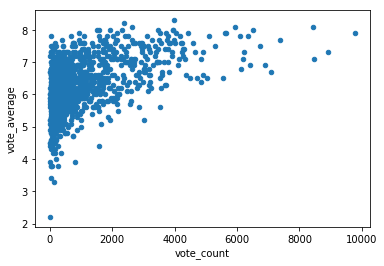

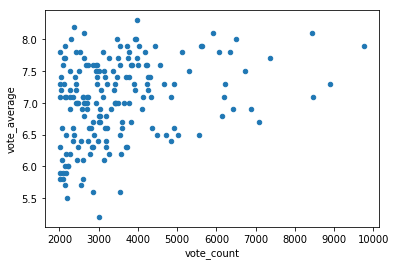

In [45]:
df_vote.plot(x='vote_count', y='vote_average', kind='scatter');
df_vote_2000.plot(x='vote_count', y='vote_average', kind='scatter');

In [46]:
df_vote.corr()


,vote_count,vote_average
vote_count,1.00,0.46
vote_average,0.46,1.00


In [47]:
 df_vote_2000.corr()


,vote_count,vote_average
vote_count,1.00,0.31
vote_average,0.31,1.00


In [48]:
# What were the most popular produced genres ?
#Creating a Mask for the release_year 2015
df_2015 = df_genres_dates[df_genres_dates['release_year'] == 2015].copy()
#drop release_year
df_2015.drop('release_year',axis=1, inplace=True)
#value_counts across columns
df_2015 = df_2015.stack().value_counts()


In [49]:
#Creating a Mask for the release_year 2000
df_2000 = df_genres_dates[df_genres_dates['release_year'] == 2000].copy()
#drop release_year
df_2000.drop('release_year',axis=1, inplace=True)
#value_counts across columns
df_2000 = df_2000.stack().value_counts()

In [50]:
#Comparing index of both dataframes
df_2015.index.sort_values(),df_2000.index.sort_values()

#Adjusting columns to have a match in columns
df_2000['Animation'] = 0
df_2000['Crime'] = 0
df_2000['History'] = 0
df_2000['Horror'] = 0
df_2000['Music'] = 0
df_2000['Western'] = 0

#Updating DataFrames, sort it by index
df_2015 = df_2015.sort_index()
df_2000 = df_2000.sort_index()

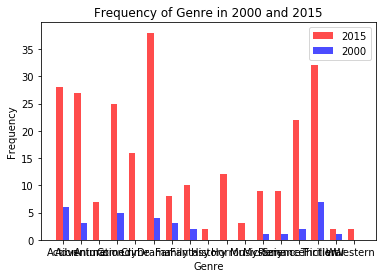

In [51]:
'''Creating a plot with a bar chart with 2 bars'''
labels = df_2000.index.sort_values()
ind = np.arange(len(df_2015))  # the x locations for the groups
width = 0.35       # the width of the bars

# plot bars
red_bars = plt.bar(ind, df_2015, width, color='r', alpha=.7, label='2015')
white_bars = plt.bar(ind + width, df_2000, width, color='b', alpha=.7, label='2000')

# title and labels
plt.ylabel('Frequency')
plt.xlabel('Genre')
plt.title('Frequency of Genre in 2000 and 2015')
locations = ind + width / 2  # xtick locations
labels = labels # xtick labels
plt.xticks(locations, labels)
plt.rcParams["figure.figsize"] = (40,50)
# legend
plt.legend();

In [52]:
#How did the amount of produced films changed over time?


In [53]:
amount_of_movies = [] #creates a list of tuples for amount of movies

#for loop to create amount_of_movies, years was previously defined
for year in years:
    d = df_genres_dates[df_genres_dates['release_year'] == year] #creates df filtered by every year mentioned in years
    e = len(d.index) #determines the number of rows 
    amount_of_movies.append((year, e)) #appends year with respective number of rows
    
#creates df for list of tuples amount_of_movies
df_amount_of_movies = pd.DataFrame(amount_of_movies, columns=['release_year', 'amount_of_mvies']).sort_values('release_year').reset_index().drop(['index'], axis=1)

,release_year,amount_of_mvies
0,1961,1
1,1962,1
2,1963,1
3,1964,2
4,1965,1
5,1967,1
6,1969,1
7,1971,4
8,1972,1
9,1973,2


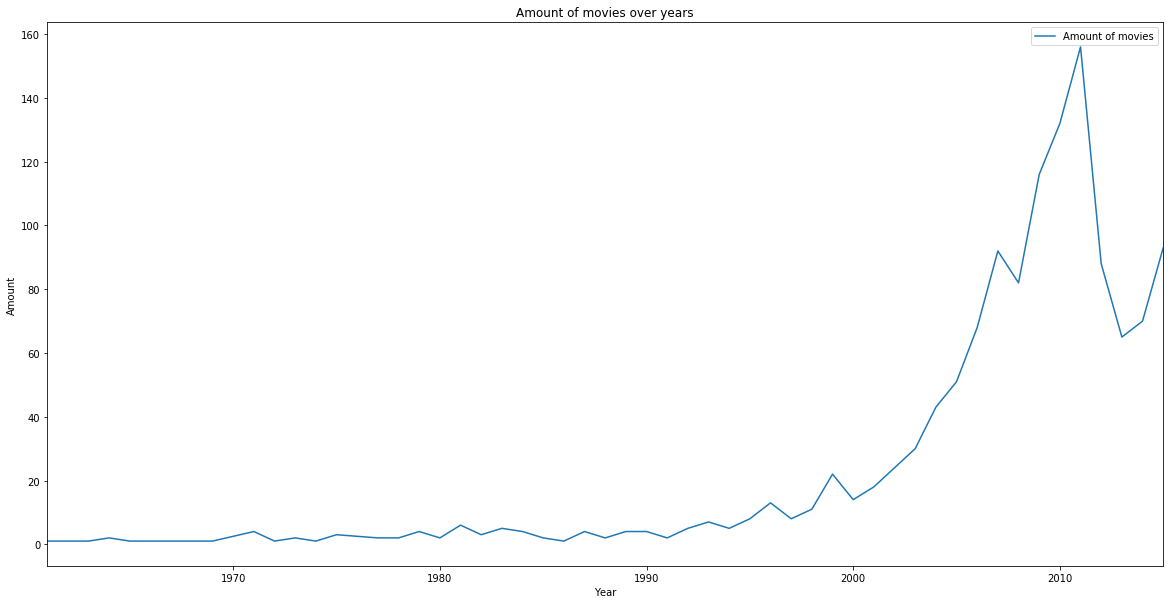

In [54]:
df_amount_of_movies.plot(x='release_year', y='amount_of_mvies', kind='line', figsize=(20,10), title="Amount of movies over years", label="Amount of movies", )
plt.xlabel('Year')
plt.ylabel('Amount');
df_amount_of_movies

<a id='conclusions'></a>
## Conclusions

The first research question, "Which genres are most popular from year to year?" yielded unexpected results, as the most popular genre varied greatly from year to year. Only 11 times, to the authors' astonishment, the most often generated genres were also picked as the greatest genre by the users. The two values differed on all of the remaining 40 occurrences.
The second research question, "What kind of attributes are related with high-grossing movies?" yields an intriguing conclusion. The "popularity," "budget," and "vote count" numeric columns have the strongest connections. Although it is possible to argue that films with bigger budgets have better revenues, the association is not very strong. The bigger the number of people that vote for a movie, the higher the revenue. This is most likely not a favorable sign for high-grossing films. High-grossing films are usually directed by Matt Damon, star Tom Cruise, and are of the action genre.
The third study question, "Did movies with more votes obtain a better rating?" does not imply that movies with more votes receive a higher vote average. Also, taking into account columns with more than 2000 vote count has little effect on the overall perception. Furthermore, the corralation shows that higher vote totals do not imply higher vote averages.
According to the fourth study question, "What were the most popular produced genres in 2000 versus 2015?" dramas were by far the most often made movies in 2015, followed by thrillers and action. The thriller was the most often produced genre in 2000, followed by action and comedies. In 2015, substantially more movies were created than in 2000, as seen by the bar chart.
The final study question, "How did the number of produced films change over time?" demonstrates that from 1960 to 2015, the number of produced films climbed dramatically. From 1983 until 2014, only about 100 movies were made per year, compared to 700 in 2014. Between 1997 and 2009, there was a significant growth in movie output. Because many rows from the original dataset were discarded, the line chart does not provide accurate findings.
All of the findings are restricted to the underlying data set, and because no advanced statistics were used, they can only be used as indications and are not generalizable. It's also worth noting that several records in the dataset were eliminated due to missing data.
. 



> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

### Limitations
> **Tip**: The conclusion assumed that higher rating rating genre such as thriller, comedy are the most popular according to correclations. Never the less, corrlation doesn’t mean causality. 
The results don’t 100% guarantee that the highest rating genre could have the same pupularing during the later years. 
.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])